### MIBI-TOF dataset to study  the spatial organization of the tumor microenvironment and breast cancer progression

#### Conditions:
1. Normal (N=9)
2. Non-progressors (ctrl) (N=44)
3. Progressors (case) (N=14)


The MIBI-TOF breast cancer data from Risom et al. is available in a public Mendeley data repository: https://data.mendeley.com/datasets/d87vg86zd8. We also make the data available as part of our package.



#### A little about our toolkit GraphCompass
GraphCompass integrates multiple graph-based and statistical approaches to compare spatial omics samples across various biological conditions at three different levels of abstraction: 
1. entire samples (entire graph comparison),
2. individual cell types (cell-type-specific subgraphs comparison), and
3. multi-cell neighborhoods (cellular neighborhood comparison).

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import graphcompass as gc

## Load data

In [2]:
adata = gc.datasets.mibitof_breast_cancer()

In [3]:
adata.obs.head()

,event,Point_Num,CohortNumber,Tissue_Type,Status,Tissue,sublineage,phenotype,compartment,celllineage,...,Neighbor_dist_BCELL,Neighbor_dist_TCELL,Neighbor_dist_NEUT,Neighbor_dist_IMMUNEOTHER,K10_cluster,duct_edge_mask,duct_mid_mask,duct_core_mask,labels_id,batch
labels_id,,,,,,,,,,,,,,,,,,,,,
2,70001,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.0,0.0,0.0,8,0,0,0,2,0
4,70003,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.0,0.0,0.0,2,1,0,0,4,0
10,70006,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.0,0.0,0.0,2,0,1,0,10,0
11,70007,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.0,0.0,0.0,2,0,1,0,11,0
13,70008,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.0,0.0,0.0,8,1,0,0,13,0


In [4]:
# preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
# filtering: discard IBC ("ipsinv") patients
adata = adata[adata.obs["Status"].isin(["case", "ctrl", "normal"])]

In [6]:
# define library_key and cluster_key for computing spatial graphs
library_key="Point_Num"  # key in adata.obs where batch/patient info is stored
cluster_key="phenotype"  # key in adata.obs where cell type/cluster info is stored

# define condition_key used in comparisons
condition_key="Status" # key in adata.obs where condition info is stored

## 1. Entire graph comparison

GraphCompass provides two methods to perform holistic graph comparisons: 

    A. Weisfeiler-Lehman graph kernels, and
    B. filtration curves.

Both methods result in graph embeddings that can be compared against one another to obtain a broad measure of tissue architecture similarity.

To compute the Weisfeiler-Lehman kernels, we run `gc.tl.wlkernel.compare_conditions`. The results are stored in `adata.uns["wl_kernel"]`.
To compute the filtration curves, we run `gc.tl.filtration_curves.compare_conditions`. The results are stored in `adata.uns["filtration_curves"]`.

We run `gc.pl.wlkernel.compare_conditions` and `gc.pl.filtration_curves.compare_conditions` to plot WL kernel results and filtration curves, respectively.

### A. Weisfeiler-Lehman graph kernels

**_Compute Weisfeiler-Lehman Graph Kernels to compare conditions_**

In [7]:
# compute WWL kernels
### results are stored in adata.uns["wl_kernel"]

gc.tl.wlkernel.compare_conditions(
   adata=adata,
   library_key=library_key,
   cluster_key=cluster_key,
   compute_spatial_graphs=True,
   kwargs_spatial_neighbors={
        'coord_type': 'generic',
        'delaunay': True,  
  }  
)

Computing spatial graphs...


100%|██████████| 1000/1000 [00:00<00:00, 3059.52/s]


Defining node features...


100%|██████████| 67/67 [00:02<00:00, 23.45it/s]
INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


Wasserstein distance between conditions...
Done!


In [8]:
adata

AnnData object with n_obs × n_vars = 57880 × 59
    obs: 'event', 'Point_Num', 'CohortNumber', 'Tissue_Type', 'Status', 'Tissue', 'sublineage', 'phenotype', 'compartment', 'celllineage', 'sublineage_code', 'phenotype_code', 'compartment_code', 'celllineage_code', 'manual_gating_cellineage', 'manual_gating_subineage', 'manual_gating_phenotype', 'innerduct_mask', 'distal_mask', 'stroma_mask', 'periph_mask', 'epi_mask', 'duct_mask', 'myoep_mask', 'ERstatus', 'HER2status', 'ARstatus', 'Ki67status', 'pS6status', 'GLUT1status', 'HIF1astatus', 'COX2status', 'CD36status', 'CD44status', 'PD1status', 'PDL1status', 'IDO1status', 'GZMBstatus', 'ECADstatus', 'MMP9status', 'VIMstatus', 'FAPstatus', 'HLADRstatus', 'CD3status', 'SMAstatus', 'COLIstatus', 'CK5status', 'CK7status', 'P63status', 'myoep_dist_label', 'myoep_dist_MinDist', 'myoep_dist_MaxDist', 'myoep_dist_MedDist', 'myoep_dist_MeanDist', 'celltype_code', 'myoep_dist_MinDist1', 'Neighbor_dist_TUMOR', 'Neighbor_dist_MYOEP', 'Neighbor_dist_FI

**_Plot Weisfeiler-Lehman Graph Kernels results_**

In [9]:
# define necessary params
control_group="normal"  # reference group
metric_key="wasserstein_distance" 
method="wl_kernel"

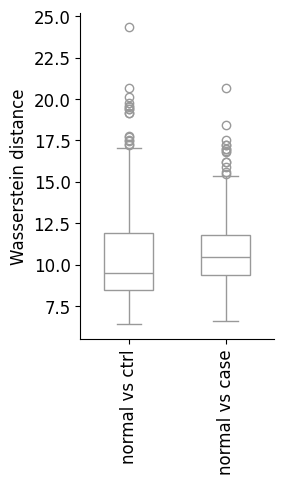

In [10]:
# note: a smaller Wasserstein distance indicates a higher similarity between the two graphs, 
# while a larger distance indicates less similarity.

gc.pl.wlkernel.compare_conditions(
    adata=adata,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    metric_key=metric_key,
    method=method,
    figsize=(3,5),
    dpi=100,
)

### B. Filtration curves

**_Compute filtration curves to compare conditions_**

In [11]:
# compute filtration curves
### results are stored in adata.uns["filtration_curves"]

# note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.filtration_curves.compare_conditions(
    adata=adata,
    library_key=library_key,
    cluster_key=cluster_key,
    condition_key=condition_key,
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }  
)

Computing spatial graph...
Computing edge weights...


100%|██████████| 67/67 [00:02<00:00, 27.98it/s]


Computing edge weight threshold values...
Creating filtration curves...


100%|██████████| 67/67 [00:00<00:00, 473.68it/s]

Done!


In [12]:
adata.obs

,event,Point_Num,CohortNumber,Tissue_Type,Status,Tissue,sublineage,phenotype,compartment,celllineage,...,Neighbor_dist_BCELL,Neighbor_dist_TCELL,Neighbor_dist_NEUT,Neighbor_dist_IMMUNEOTHER,K10_cluster,duct_edge_mask,duct_mid_mask,duct_core_mask,labels_id,batch
labels_id,,,,,,,,,,,,,,,,,,,,,
2,70001,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,8,0,0,0,2,0
4,70003,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,1,0,0,4,0
10,70006,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,0,1,0,10,0
11,70007,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,2,0,1,0,11,0
13,70008,2203,3,DCIS,ctrl,DCIS,TUMOR,TUMOR_LUMINAL,epithelial,tumor,...,0.0,0.000000,0.000,0.000000,8,1,0,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,38134,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.000000,0.000,0.000000,10,0,0,0,1317,78
1321,38137,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.083333,0.000,0.041667,10,0,0,0,1321,78
1342,38148,6206,161,DCIS,ctrl,DCIS,APC,APC,stroma,immune,...,0.0,0.045455,0.000,0.090909,10,0,0,0,1342,78


**_Plot filtration curves results_**

In [13]:
# define necessary params
node_labels=["MYOEP", "MONO", "MACS"]  # node labels (e.g. cell types) we are interested in visualising
metric_key="filtration_curves"

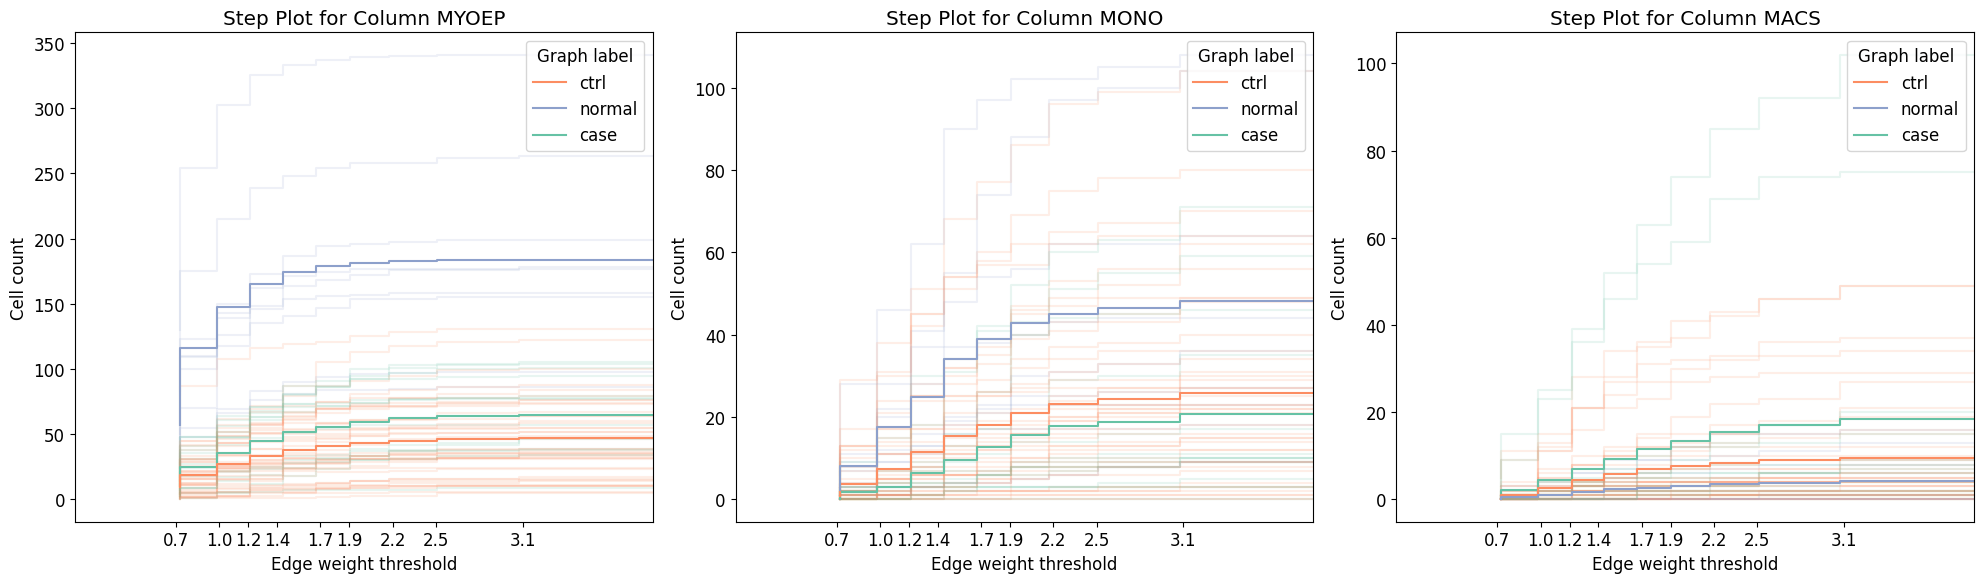

In [14]:
gc.pl.filtration_curves.compare_conditions(
    adata=adata,
    node_labels=node_labels,
    metric_key=metric_key,
    palette="Set2",
    dpi=100,
    figsize=(20,6),
    right=4,  # to shorten the x-axis and improve readability
)

## 2. Specific-cell-type subgraphs comparison

GraphCompass contains two graph distance metrics to compare cell-type-specific graphs between different conditions: the portrait and diffusion method. Both methods provide similarity scores between two networks of cells that represent two different conditions.

To calculate the metrics, we run `gc.tl.distance.compare_condition` (with method in ["diffusion", "portait"]).

To plot the results, we run `gc.pl.distance.compare_condition`.

In this tutorial we will focus only on the *portrait method*.

_Note: the plotting function for the diffusion method is still under development._

**_Compute distances between cell-type specific subgraphs using the portrait method to compare conditions_**

In [15]:
# compute pairwise similarities between cell-type-specific graphs across samples
### results are stored in adata.uns["pairwise_similarities"]

# note: in our case, the spatial graphs have been computed previously (to obtain the WL kernels), so we can set
## `compute_spatial_graphs` to False to save compute time. Otherwise, it should be set to True and 
## `kwargs_spatial_neighbors` should be set depending on the technology used to obtain the spatial data.

gc.tl.distance.compare_conditions(
    adata=adata,
    library_key=library_key,
    cluster_key=cluster_key,
    method="portrait",
    compute_spatial_graphs=False,
#     kwargs_spatial_neighbors={
#         'coord_type': 'generic',
#         'delaunay': True,  
#     }
)

Spatial graphs were previously computed. Skipping computing spatial graphs 
Computing graph similarities...


100%|██████████| 23/23 [26:00<00:00, 67.85s/it]  

Done!


In [16]:
adata

AnnData object with n_obs × n_vars = 57880 × 59
    obs: 'event', 'Point_Num', 'CohortNumber', 'Tissue_Type', 'Status', 'Tissue', 'sublineage', 'phenotype', 'compartment', 'celllineage', 'sublineage_code', 'phenotype_code', 'compartment_code', 'celllineage_code', 'manual_gating_cellineage', 'manual_gating_subineage', 'manual_gating_phenotype', 'innerduct_mask', 'distal_mask', 'stroma_mask', 'periph_mask', 'epi_mask', 'duct_mask', 'myoep_mask', 'ERstatus', 'HER2status', 'ARstatus', 'Ki67status', 'pS6status', 'GLUT1status', 'HIF1astatus', 'COX2status', 'CD36status', 'CD44status', 'PD1status', 'PDL1status', 'IDO1status', 'GZMBstatus', 'ECADstatus', 'MMP9status', 'VIMstatus', 'FAPstatus', 'HLADRstatus', 'CD3status', 'SMAstatus', 'COLIstatus', 'CK5status', 'CK7status', 'P63status', 'myoep_dist_label', 'myoep_dist_MinDist', 'myoep_dist_MaxDist', 'myoep_dist_MedDist', 'myoep_dist_MeanDist', 'celltype_code', 'myoep_dist_MinDist1', 'Neighbor_dist_TUMOR', 'Neighbor_dist_MYOEP', 'Neighbor_dist_FI

**_Plot portrait method results_**

In [17]:
# define necessary params
control_group="normal"  # reference group

23it [00:58,  2.54s/it]


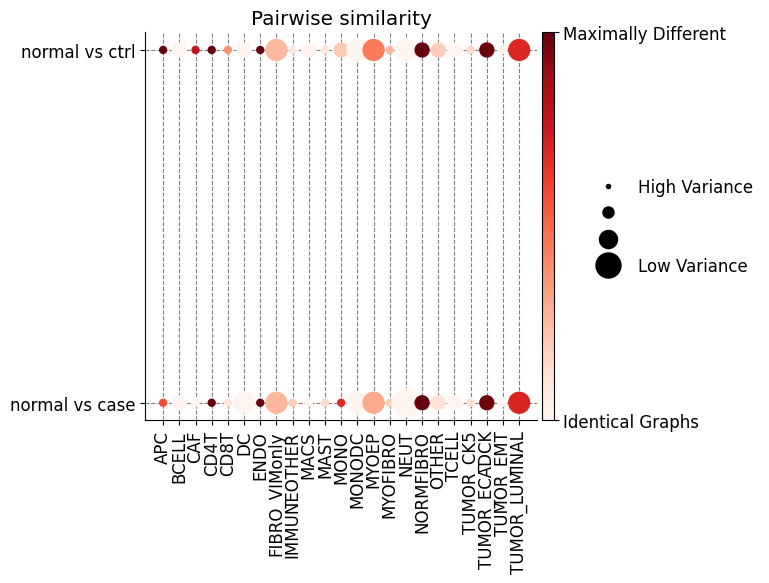

In [18]:
# note: The size of the dot is indicative of the similarity score variance over samples. 
# The larger the dot size, the lower the score variance and the higher our score confidence is.

gc.pl.distance.compare_conditions(
    adata=adata,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    palette="Reds",
    dpi=100,
    figsize=(8,6),
)

## 3. Cellular neighborhood comparison

GraphCompass leverages Generalized Linear Models (GLMs) to compare cellular neighborhoods between different conditions. 

Refer to the `notebooks/cellular_neighborhoods/` folder for this analysis, which consists of 2 steps (enrichment calculation and GLM training).

Note: some of the code for the cellular neighborhood comparison was originally written in R and has since been migrated to Python. There are therefore two GLM training notebooks: a Python-based version and a legacy R version. Results were not affected by this migration.
